In [383]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gradient Boosting

## Read Data

In [384]:
#data from here https://www.kaggle.com/c/boston-housing/overview
df = pd.read_csv('https://raw.githubusercontent.com/shestakoff/hse_se_ml/master/2020/s11-boosting/data/boston_train.csv').drop(columns = 'ID')

 Prediction of house price in Boston.
 
 Why it's important? Because it can help people determine a fair price at home.

In [385]:
X = df.drop(columns = 'medv').values
y = df['medv'].values

In [386]:
X.shape

(333, 13)

## Before doing

definition of huber_loss: https://en.wikipedia.org/wiki/Huber_loss

Implement a function that calculates $z_i$ from gradient boosting algorithm (minus gradient of loss function). Implement for all possible loss functions (mse, hl, logloss)

In hl use $\delta = 1$, assume that $MSE = \frac{1}{2}(r - y)^2$ and log_loss(sigmoid(r)) use $0$ and $1$ like class label

In [387]:
def calc_objective(r, target, loss = 'mse'):
    """
    Parameters
        ----------
        r : np.array
            value of f(x)
        target : np.array
            target
        loss : str
            loss function. Possible values : mse, hl(https://en.wikipedia.org/wiki/Huber_loss, logloss(sigmoid(r))
    """
    ret = []
    delta = 1
    
    if(loss=='logloss'):
        import math
        
        for i in range(r.shape[0]):
            sig_r = 1 / (1 + math.exp(-r[i] * target[i]))
            if(target[i] == 0):
                ret.append(- 1 / (1 + math.exp(-r[i])))
            else:
                ans = (math.exp(-r[i] * target[i]) * target[i])
                ret.append(ans * sig_r)
        return ret
    
    for i in range(r.shape[0]):
        if(abs(r[i] - target[i]) > delta and loss=='hl'):
                l =  -(r[i] - target[i])/abs(r[i] - target[i])
        else:
            l = -(r[i] - target[i])
        ret.append(l)
    return ret

    

In [388]:
#test your code

r = np.array([1, 2, 3, 4, 5])
target = np.array([10, 9, 8, 7, 6])
assert(np.allclose(calc_objective(r, target, 'mse'), np.array([9, 7, 5, 3, 1]), 0.00001))

r = np.array([2, 4, 7, 9, 13])
target = np.array([2.5, 6, 10, 6, 12.75])
assert(np.allclose(calc_objective(r, target, 'hl'), np.array([0.5, 1, 1, -1, -0.25]), 0.00001))

r = np.array([0, np.log(2), -np.log(9), np.log(4), np.log(19)])
target = np.array([0, 1, 0, 1, 1])
assert(np.allclose(calc_objective(r, target, 'logloss'), np.array([-0.5, 1. / 3, -0.1, 0.2, 0.05]), 0.00001))

Implement function which make one step of gradient boossting (fit new estimator)

In [389]:
def step(X, y, r, base_estimator, loss = 'mse'):
    """
    Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the target variables
        r : np.array, shape = (n_ojects)
            f_{m-1}(X) (X matrix of features) - prediction of previous m-1 base_estimators
        base_estimator : estimator which you must fit
            has got method fit
        loss : str
            loss function. Possible values : mse, hl, logloss
            
        Return fitted base_estimator
    """
    
    z = - calc_objective(r, y, loss)
    
    base_estimator.fit(X, z)
    
    return base_estimator

## Now use your knowledge and implement gradient boosting

# Task 1 (6 points)

Implement GradientBoostingRegressor as it was described in your lectures:

**Input**: training dataset $(x_{i},y_{i}),\,i=1,2,...N$; loss function $\mathcal{L}(f,y)$; learning rate $\nu$ and the number $M$ of successive additive approximations.

1. Fit initial approximation $f_{0}(x)$ (might be taken $f_{0}(x)\equiv0$)
2. For each step $m=1,2,...M$:

    1. calculate derivatives $z_{i}=-\frac{\partial\mathcal{L}(r,y_{i})}{\partial r}|_{r=f^{m-1}(x_{i})}$
    2. fit $h_{m}$ to $\{(x_{i},z_{i})\}_{i=1}^{N}$, for example by solving
$$
\sum_{n=1}^{N}(h_{m}(x_{n})-z_{n})^{2}\to\min_{h_{m}}
$$
    4. set $f_{m}(x)=f_{m-1}(x)+\nu h_{m}(x)$


**Output**: approximation function $f_{M}(x)=f_{0}(x)+\sum_{m=1}^{M}\nu h_{m}(x)$

Implement three loss functions:

    1 MSE
    2 Huber loss(https://en.wikipedia.org/wiki/Huber_loss)
    3 log_loss (in this case we solve classification task
In our case $h_m$ is DecisionTreeRegressor

In [390]:
from sklearn.tree import DecisionTreeRegressor

In [391]:
# You need to modify this class #

class GradientBoostingEstimator(object):

    def __init__(self, n_estimators, max_depth = 3, max_leaf_nodes = 8, n_subset_features = 5, random_state = 42,
                 loss = 'mse', learning_rate=0.1):
        """
        This is your random forest classifier.
        
        Parameters
        ----------
        n_estimators : int
            Number of estimators to train.
        max_depth : int
            max_depth of DecisionTreeRegressor
        max_leaf_nodes:
            max_leaf_nodes of DecisionTreeRegressor
        n_subset_features : int
            Number of random features to used to train a decision tree
        random_state : int
            random_state for decision tree
        loss : str
            Loss. Possible values : mse, hl, logloss
        learning_rate : float
            learning_rate (coef for next estimator on each step)
        """
        
        self.n_estimators = n_estimators
        
        self.learning_rate = learning_rate
        
        self.max_depth = max_depth
        self.max_leaf_nodes = max_leaf_nodes
        self.n_subset_features = n_subset_features
        self.random_state = random_state
        
        self.loss = loss
        self.nu = learning_rate
        
        self.regressors = []
    
    
    def calc_objective(self, r, target, loss = 'mse'):
        """
    Parameters
        ----------
        r : np.array
            value of f(x)
        target : np.array
            target
        loss : str
            loss function. Possible values : mse, hl(https://en.wikipedia.org/wiki/Huber_loss, logloss(sigmoid(r))
        """
        ret = []
        delta = 1
    
        if(loss=='logloss'):
            import math
        
            for i in range(r.shape[0]):
                sig_r = 1 / (1 + math.exp(-r[i] * target[i]))
                if(target[i] == 0):
                    ret.append(- 1 / (1 + math.exp(-r[i])))
                else:
                    ans = (math.exp(-r[i] * target[i]) * target[i])
                    ret.append(ans * sig_r)
            return ret
    
        for i in range(r.shape[0]):
            if(abs(r[i] - target[i]) > delta and loss=='hl'):
                l =  (r[i] - target[i])/abs(r[i] - target[i])
            else:
                l = -(r[i] - target[i])
            ret.append(l)
        return ret
    
    
    def fit(self, X, y):
        """
        Fit the classifier.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        #Initial f_{0}(X)
        
        self.r = np.zeros(X.shape[0], dtype=float)
        
        #1-M fittings
        
        for i in range(self.n_estimators):
               
            rgr = DecisionTreeRegressor(max_depth=self.max_depth, max_leaf_nodes=self.max_leaf_nodes, 
                                                 random_state = self.random_state)
            
            self.z = self.calc_objective(self.r, y, self.loss)
            
            rgr.fit(X, self.z)
            
            self.regressors.append(rgr)
            
            self.r = self.r + self.nu * rgr.predict(X)
            
            
    def predict(self, X):
        """
        This methods performs labels prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        labels : numpy.array, shape = (n_objects)
            1D array with predicted labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        res = np.zeros(X.shape[0])
        
        for regressor in self.regressors:
            res = res + self.nu * regressor.predict(X)
            
        return res
        
    def predict_proba(self, X):
        """
        This methods performs probabilities prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        proba : numpy.array, shape = (n_objects, n_classes)
            Array with predicted probabilities. 
        """
        
        res = np.zeros(X.shape[0])
        
        for regressor in self.regressors:
            res = res + self.nu * regressor.predict(X)
            
        res = 1/(1+np.exp(-res))
            
        return res

### Important
When you select `learning_rate` and `n_estimators`, follow the default values of the tree parameters

# Task 2 (2 points)

Split your data on train, valid sample (fix random_seed). Choose the best `learning_rate` and `n_estimators` for every loss (for logloss use data from previous HW). For regression task (mse_loss, huber_loss) use MSE on valid sample as quality measure to choose optimal params, for classification task (logloss) use ROC-AUC.

In [392]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc

#data from here https://www.kaggle.com/c/boston-housing/overview
df = pd.read_csv('https://raw.githubusercontent.com/shestakoff/hse_se_ml/master/2020/s11-boosting/data/boston_train.csv').drop(columns = 'ID')

X = df.drop(columns = 'medv').values
y = df['medv'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.5,
random_state=123)

results = []

n_estimators = np.arange(100, 500, 50)

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

In [393]:
%%time

min_mse = 1000000
best_learning_rate = 0
best_n_estimators = 0

for lr in learning_rate:
    for n in n_estimators:
        clf = GradientBoostingEstimator(learning_rate=lr, n_estimators=n)
        clf.fit(X_train, y_train)
        proba = clf.predict(X_test)
        mse = 1/y_test.shape[0] * (proba.mean() - y_test.mean())**2
        if(mse < min_mse):
            min_mse = mse
            best_learning_rate=lr
            best_n_estimators=n
    
print("min_mse = ", min_mse)
print("best_learning_rate = ", best_learning_rate)
print("best_n_estimators = ", n)

min_mse =  2.7972277172892767e-06
best_learning_rate =  0.1
best_n_estimators =  450
Wall time: 8.22 s


In [394]:
%%time

for lr in learning_rate:
    for n in n_estimators:
        clf = GradientBoostingEstimator(learning_rate=lr, n_estimators=n, loss='hl')
        clf.fit(X_train, y_train)
        proba = clf.predict(X_test)
        mse = 1/y_test.shape[0] * (proba.mean() - y_test.mean())**2
        if(mse < min_mse):
            min_mse = mse
            best_learning_rate=lr
            best_n_estimators=n
            
print("min_mse = ", min_mse)
print("best_learning_rate = ", best_learning_rate)
print("best_n_estimators = ", n)

min_mse =  2.7972277172892767e-06
best_learning_rate =  0.1
best_n_estimators =  450
Wall time: 5.99 s


In [295]:
%%time

df_X = pd.read_csv('x_train.csv', sep=';')
df_y = pd.read_csv('y_train.csv', sep=';', header=None, names=['target'])

X = df_X.values
y = df_y['target'].values

n_estimators = np.arange(100, 500, 100)

learning_rate = [0.0001, 0.001, 0.01, 0.1]

X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.5,
random_state=123)

max_acc = 0
best_learning_rate = 0
best_n = 0

for lr in learning_rate:
    for n in n_estimators:
        clf = GradientBoostingEstimator(learning_rate=lr, n_estimators=n, loss='logloss')
        
        clf.fit(X_train, y_train)
        proba = clf.predict_proba(X_test)
        
        accuracy = roc_auc_score(y_test, proba)
        
        if(accuracy > max_acc):
            max_acc = accuracy
            best_learning_rate = lr
            best_n = n
            
print("max_acc = ", max_acc)
print("best_learning_rate = ", best_learning_rate)
print("best_n_estimators = ", best_n)

max_acc =  0.8775739710743772
best_learning_rate =  0.1
best_n_estimators =  300
Wall time: 2min 52s


# Task 3 (1 point)
Plot dependecy of loss value (in classification task plot roc-auc score) from `n_estimators` of your boosting. Use `learning_rate=0.1`.

In [395]:
#data from here https://www.kaggle.com/c/boston-housing/overview
df = pd.read_csv('https://raw.githubusercontent.com/shestakoff/hse_se_ml/master/2020/s11-boosting/data/boston_train.csv').drop(columns = 'ID')

X = df.drop(columns = 'medv').values
y = df['medv'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.5,
random_state=123)

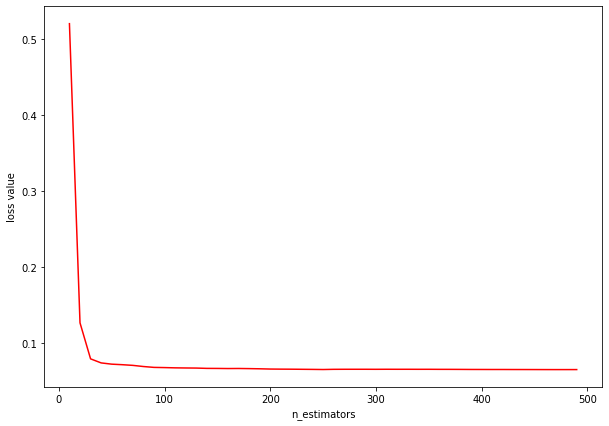

In [396]:
n_estimators = np.arange(10,500, 10)

values = []

for n in n_estimators:
    clf = GradientBoostingEstimator(n_estimators=n, learning_rate= 0.1, loss = 'mse')
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    mse = ((y_pred - y_test)**2)/y_pred.shape
    values.append(mse.mean())
    
plt.figure(figsize=(10, 7))
plt.plot(n_estimators, values, 'r')
plt.xlabel('n_estimators')
plt.ylabel('loss value')
plt.show()

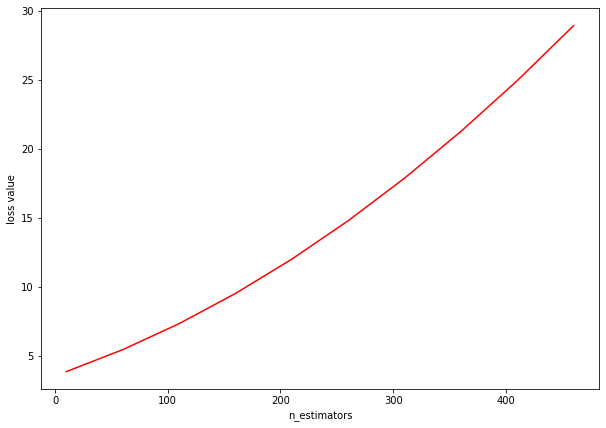

In [397]:
n_estimators = np.arange(10,500, 50)

values = []

for n in n_estimators:
    clf = GradientBoostingEstimator(n_estimators=n, learning_rate= 0.1, loss = 'hl')
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    mse = ((y_pred - y_test)**2)/y_pred.shape
    values.append(mse.mean())
plt.figure(figsize=(10, 7))
plt.plot(n_estimators, values, 'r')
plt.xlabel('n_estimators')
plt.ylabel('loss value')
plt.show()

In [398]:
df_X = pd.read_csv('x_train.csv', sep=';')
df_y = pd.read_csv('y_train.csv', sep=';', header=None, names=['target'])

X = df_X.values
y = df_y['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.5,
random_state=123)

4


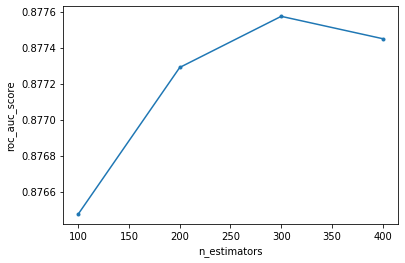

In [322]:
n_estimators = np.arange(100, 500, 100)

res =[]

for n in n_estimators:
    clf = GradientBoostingEstimator(n_estimators=n, learning_rate=0.1, loss='logloss')
    
    clf.fit(X_train, y_train)
    
    proba = clf.predict_proba(X_test)
    
    rfc_auc = roc_auc_score(y_test, proba)
    
    res.append(rfc_auc)  
    
plt.plot(n_estimators, res, marker='.')

plt.xlabel('n_estimators')
plt.ylabel('roc_auc_score')

plt.show()

# Task 4 (1 point)
Plot dependecy of loss value (in classification task plot roc-auc score) from `learning_rate` of your boosting. Use `n_estimators=100`.

In [380]:
#data from here https://www.kaggle.com/c/boston-housing/overview
df = pd.read_csv('https://raw.githubusercontent.com/shestakoff/hse_se_ml/master/2020/s11-boosting/data/boston_train.csv').drop(columns = 'ID')

X = df.drop(columns = 'medv').values
y = df['medv'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.5,
random_state=123)

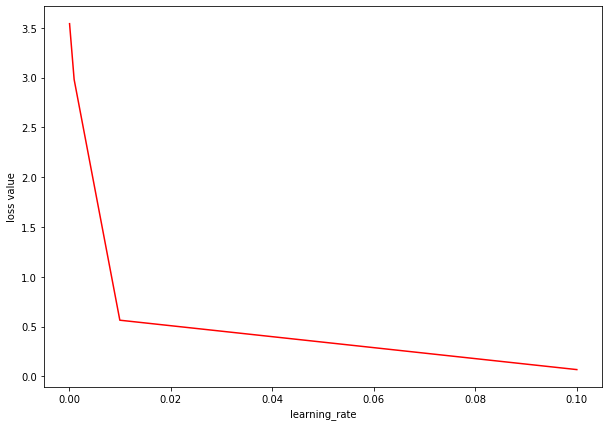

In [381]:
learning_rate = [0.0001, 0.001, 0.01, 0.1]

scores = []

for n in learning_rate:
    clf = GradientBoostingEstimator(n_estimators=100, learning_rate=n, loss = 'mse')
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    mse = ((y_pred - y_test)**2)/y_pred.shape
    scores.append(mse.mean())
    
plt.figure(figsize=(10, 7))
plt.plot(learning_rate, scores, 'r')
plt.xlabel('learning_rate')
plt.ylabel('loss value')
plt.show()

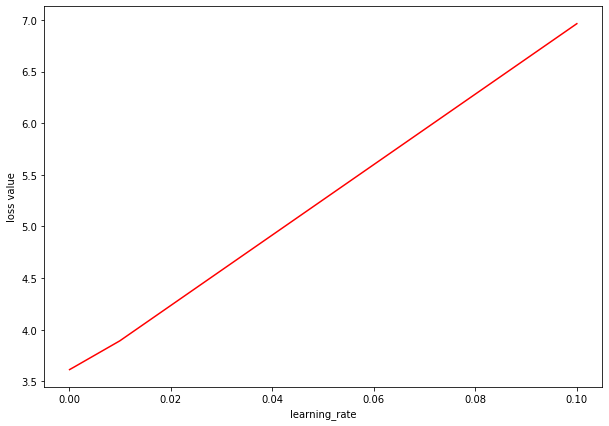

In [382]:
learning_rate = [0.0001, 0.001, 0.01, 0.1]

scores = []

for n in learning_rate:
    clf = GradientBoostingEstimator(n_estimators=100, learning_rate=n, loss = 'hl')
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    mse = ((y_pred - y_test)**2)/y_pred.shape
    scores.append(mse.mean())
    
plt.figure(figsize=(10, 7))
plt.plot(learning_rate, scores, 'r')
plt.xlabel('learning_rate')
plt.ylabel('loss value')
plt.show()

In [379]:
df_X = pd.read_csv('x_train.csv', sep=';')
df_y = pd.read_csv('y_train.csv', sep=';', header=None, names=['target'])

X = df_X.values
y = df_y['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.5,
random_state=123)

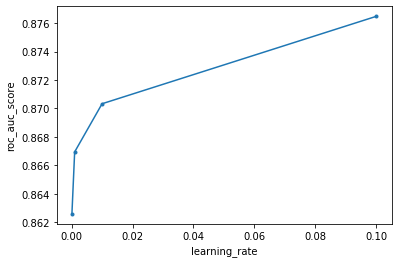

In [364]:
learning_rate = [0.0001, 0.001, 0.01, 0.1]

res =[]

for n in learning_rate:
    clf = GradientBoostingEstimator(n_estimators=100, learning_rate=n, loss='logloss')
    
    clf.fit(X_train, y_train)
    
    proba = clf.predict_proba(X_test)
    
    rfc_auc = roc_auc_score(y_test, proba)
    
    res.append(rfc_auc)

plt.plot(learning_rate, res, marker='.')

plt.xlabel('learning_rate')
plt.ylabel('roc_auc_score')

plt.show()